**A faire pour faire fonctionner le code sur Colab**

Montez Google Drive pour utiliser le dataset dans le cloud :

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Remplacer dans la variable "dataset_path" le chemin d'accès vers la racine du dataset dans votre google drive

In [ ]:
dataset_path = '/content/drive/MyDrive/School/PolyMTL/Courses/INF6804_Vision_Ordinateur/Travaux_Pratique/TP1/TP1_data'
#dataset_path = '/content/drive/MyDrive/School/PolyMTL/Courses/INF6804_Vision_Ordinateur/Travaux_Pratique/TP1/data_crop'

**Vous pouvez "Run all" sous l'onglet runtime**

Utilisation de Clip par openAI sur github (https://github.com/openai/CLIP) :

In [ ]:
"""
$ conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
$ pip install ftfy regex tqdm
$ pip install git+https://github.com/openai/CLIP.git
"""
#On colab :

!pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 -f https://download.pytorch.org/whl/torch_stable.html
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git


## Normalisation des noms

In [ ]:
def nettoyer_et_comparer(str1, str2):

    str1_clean = str1.split("_")[0]
    str2_clean = str2.split("_")[0]

    return str1_clean == str2_clean

## Enumération des Erreurs

In [ ]:
def error_by_image(cos_similarity, threshold, req, cmp):

  fake_pos = 0
  fake_neg = 0

  resultat = nettoyer_et_comparer(req, cmp)

  if cos_similarity > threshold:
    if resultat == False:
      fake_pos += 1
  else:
    if resultat == True:
      fake_neg += 1

  return fake_pos, fake_neg

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def compare_dictionaries(dict1, dict2, threshold=0.7, ranking_plot=False):

    fake_tot = 0
    fake_pos_req = {}
    fake_neg_req = {}

    for req in dict1.keys():
        ranking = {}  # Remise à zéro du ranking pour chaque requête
        vec1 = np.array(dict1[req])

        if ranking_plot:
            print(f"Image de référence : {req}")
            ref_image = cv2.imread(dataset_path + '/' + req)
            ref_image = cv2.cvtColor(ref_image, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(4, 4))
            plt.imshow(ref_image)
            plt.title("Image de Référence")
            plt.axis('off')
            plt.show()

        fake_pos_byquerry = 0
        fake_neg_byquerry = 0

        for cmp in dict2.keys():
            vec2 = np.array(dict2[cmp])
            cos_similarity = cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))[0][0]

            if cos_similarity > threshold:
                ranking[cmp] = cos_similarity  # Stockage des images similaires

            # Simulation des erreurs
            fake_pos, fake_neg = error_by_image(cos_similarity, threshold, req, cmp)
            fake_pos_byquerry += fake_pos
            fake_neg_byquerry += fake_neg
            fake_tot += fake_pos + fake_neg

        # Assurer que toutes les images sont présentes, même avec des erreurs à 0
        fake_pos_req[req] = fake_pos_byquerry
        fake_neg_req[req] = fake_neg_byquerry

        #  Affichage des images triées par similarité décroissante
        if ranking_plot:
            sorted_ranking = sorted(ranking.items(), key=lambda x: x[1], reverse=True)
            num_images = len(sorted_ranking)

            plt.figure(figsize=(4 * max(1, num_images), 4))
            for idx, (cmp, similarity) in enumerate(sorted_ranking):
                image = cv2.imread(path_to_database + '/' + cmp)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                plt.subplot(1, max(1, num_images), idx + 1)
                plt.imshow(image)
                plt.title(f"Sim: {similarity:.2f}")
                plt.axis('off')

            plt.tight_layout()
            plt.show()

    #  Affichage des histogrammes des erreurs après les rankings
    if ranking_plot:
        # Affichage des faux positifs (y compris ceux à 0)
        plt.figure(figsize=(10, 4))
        plt.bar(fake_pos_req.keys(), fake_pos_req.values(), color='red')
        plt.title(f'Nombre de Faux Positifs avec seuil de {threshold} sur CLIP')
        plt.ylim(0, 10)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # Affichage des faux négatifs (y compris ceux à 0)
        plt.figure(figsize=(10, 4))
        plt.bar(fake_neg_req.keys(), fake_neg_req.values(), color='blue')
        plt.title(f'Nombre de Faux Négatif avec seuil de {threshold} sur CLIP')
        plt.ylim(0, 10)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    return fake_tot

## Implémentation de CLIP

In [ ]:
import torch
import clip
from PIL import Image
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import zipfile
import shutil
import numpy as np
import math
from sklearn.metrics.pairwise import cosine_similarity
import time

model_name = "ViT-B/32"
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(model_name, device=device) #model/batch
path_to_database=''

In [ ]:
print(clip.available_models())

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


## Extraction des noms d'images

In [ ]:
# Extraction des noms d'image
img_reference_Name=[]
img_comp_Name=[]
img_extention='.jpg'
for item in os.listdir(dataset_path):
  if item.endswith(img_extention):
    img_reference_Name.append(item)
  else:
    path_to_database=dataset_path+'/'+item
    for elem in os.listdir(path_to_database):
      if elem.endswith(img_extention):
        img_comp_Name.append(elem)

## Récupération des caractéritiques d'une image via "model.encode_image(image)"

In [ ]:
start_time = time.time()
# Extraction des features CLIP pour toutes les images(image de reference et image base données)
clip_features_dict_cmp = {}
clip_features_dict_rq = {}
for image_cmp in img_comp_Name:

  image = preprocess(Image.open(path_to_database+'/'+image_cmp)).unsqueeze(0).to(device)

  with torch.no_grad():
      image_features_cmp = model.encode_image(image)

      # Stocker les features dans le dictionnaire avec le nom de l'image comme clé
      clip_features_dict_cmp[image_cmp] = image_features_cmp

for image_rq in img_reference_Name:

  # image = resize_padding(path_to_database+'/'+image_rq)
  image = preprocess(Image.open(dataset_path+'/'+image_rq)).unsqueeze(0).to(device)

  with torch.no_grad():
      image_features_rq = model.encode_image(image)

      # Stocker les features dans le dictionnaire avec le nom de l'image comme clé
      clip_features_dict_rq[image_rq] = image_features_rq

end_time = time.time()

# Calcul et affichage du temps d'exécution
execution_time = end_time - start_time
print(f"Temps d'exécution total pour l'extraction des features CLIP : {execution_time:.2f} secondes")

Temps d'exécution total pour l'extraction des features CLIP : 14.14 secondes


## Comparaison sous différents seuils et affichages

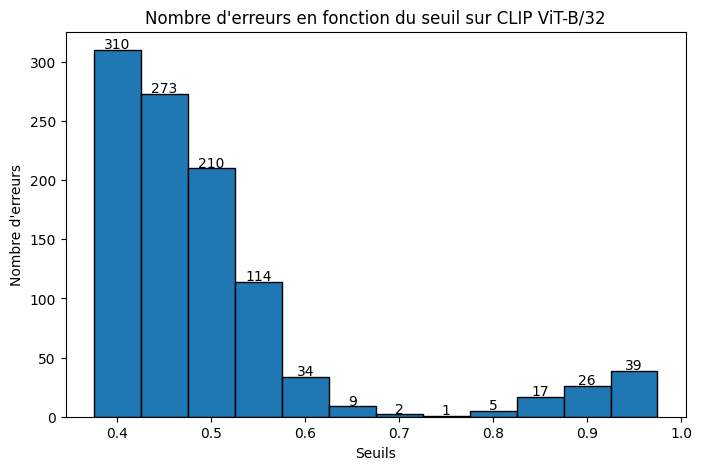

In [ ]:
import matplotlib.pyplot as plt

# Listes pour stocker les seuils et leurs erreurs associées
seuils = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]  # Exemple de seuils
erreurs = []  # Liste vide pour stocker les erreurs

# Calcul des erreurs pour chaque seuil
for seuil in seuils:
    erreur_tot = compare_dictionaries(clip_features_dict_rq, clip_features_dict_cmp, seuil)
    erreurs.append(erreur_tot)

# Création de l'histogramme
plt.figure(figsize=(8, 5))
plt.bar(seuils, erreurs, width=0.05, edgecolor="black")

# Ajout des labels et du titre
plt.xlabel("Seuils")
plt.ylabel("Nombre d'erreurs")
plt.title(f"Nombre d'erreurs en fonction du seuil sur CLIP {model_name}")

# Affichage des valeurs sur les barres
for i, v in enumerate(erreurs):
    plt.text(seuils[i], v + 1, str(v), ha="center", fontsize=10)

# Affichage du graphique
plt.show()


utilisation de la fonction compare_dictionaries() : \
**Arg1** : dictonnaire des features de requête (déjà créer avec "run all")\
**Arg2** : dictonnaire des features des images comparaison (déjà créer avec "run all")\
**Arg 3** : meilleur seuil\
**Arg 4** : Affichage de l'ordre de similarité = True, False sinon

## Comparer les dictionnairess et recherche d'images dans la base de données

In [ ]:
compare_dictionaries(clip_features_dict_rq,clip_features_dict_cmp,0.75, ranking_plot=True)

Output hidden; open in https://colab.research.google.com to view.